In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from scipy.stats import skew, norm, yeojohnson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from scipy import stats

In [76]:
shops = pd.read_csv("./shops.csv")
sales = pd.read_csv("./sales_train.csv")
items = pd.read_csv("./items.csv")
categories = pd.read_csv("./item_categories.csv")

test = pd.read_csv("./test.csv")

In [77]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [78]:
# Let's merge dataframes into a single one

sales_combined = pd.merge(sales, items, left_on='item_id', right_on='item_id', how='left')
sales_combined = pd.merge(sales_combined, shops, left_on='shop_id', right_on='shop_id', how='left')
sales_combined = pd.merge(sales_combined, categories, left_on='item_category_id', right_on='item_category_id', how='left')

sales_combined = sales_combined.drop(['item_id', 'shop_id', 'item_category_id'], axis=1)

sales_combined.head(10)

,date,date_block_num,item_price,item_cnt_day,item_name,shop_name,item_category_name
0,02.01.2013,0,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
5,10.01.2013,0,349.00,1.0,DEEP PURPLE Perihelion: Live In Concert DVD (К...,"Москва ТРК ""Атриум""",Музыка - Музыкальное видео
6,02.01.2013,0,549.00,1.0,DEEP PURPLE Stormbringer (фирм.),"Москва ТРК ""Атриум""",Музыка - CD фирменного производства
7,04.01.2013,0,239.00,1.0,DEFTONES Koi No Yokan,"Москва ТРК ""Атриум""",Музыка - CD локального производства
8,11.01.2013,0,299.00,1.0,DEFTONES Koi No Yokan,"Москва ТРК ""Атриум""",Музыка - CD локального производства
9,03.01.2013,0,299.00,3.0,DEL REY LANA Born To Die,"Москва ТРК ""Атриум""",Музыка - CD локального производства


In [79]:
# Split the date

sales_combined['formatted_date'] = pd.to_datetime(sales_combined['date'])
sales_combined['month'] = sales_combined['formatted_date'].dt.month
sales_combined['year'] = sales_combined['formatted_date'].dt.year
sales_combined = sales_combined.drop(['date', 'formatted_date'], axis=1)

sales_combined.head(5)

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '15.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '13.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '16.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Administrator\AppData\Roaming\Python\Python39\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning:

Parsing '26.01.2013' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

C:\Users\Administrator\AppData\Roami

,date_block_num,item_price,item_cnt_day,item_name,shop_name,item_category_name,month,year
0,0,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,2,2013
1,0,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",Музыка - Винил,3,2013
2,0,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,"Москва ТРК ""Атриум""",Музыка - Винил,5,2013
3,0,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,"Москва ТРК ""Атриум""",Музыка - Винил,6,2013
4,0,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1,2013


<AxesSubplot:>

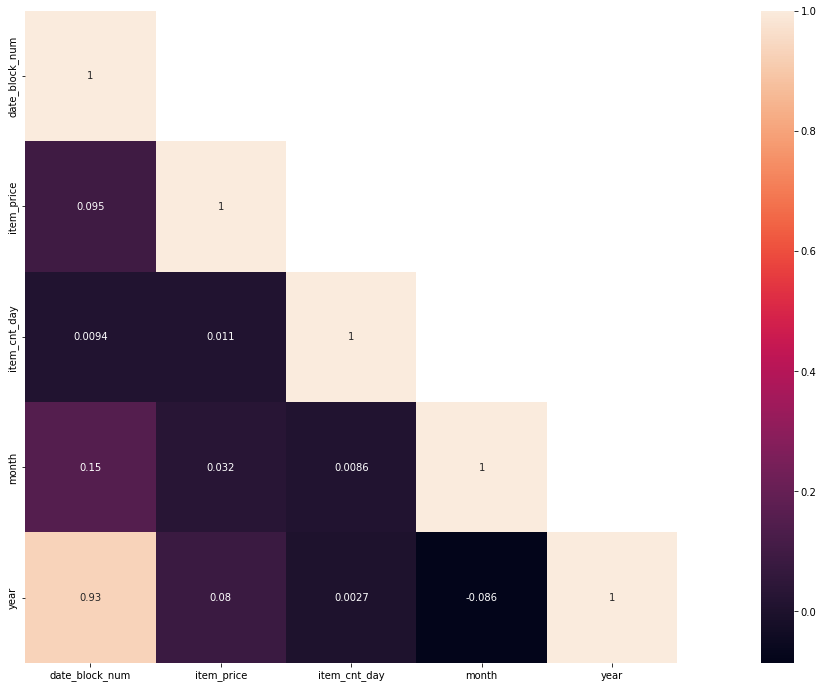

In [80]:
# Let's check correlations between parameters

cor_mat = sales_combined[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30, 12)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True)


In [81]:
# Create new variable for the sake of simplicity

train = sales_combined

In [82]:
# Let's take a look at the sales throughout the given period of time

import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

daily_sales = train.groupby('date_block_num', as_index = False)['item_cnt_day'].sum()

daily_sales_sc = go.Scatter(x=daily_sales['date_block_num'], y=daily_sales['item_cnt_day'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Time (2013 - 2015)'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [83]:
# Delete negative values (LOL, why are they negative)

train.drop(train[train.item_cnt_day < 0].index, inplace=True)
train.drop(train[train.item_price < 0].index, inplace=True)


In [84]:
# Encode all the string values

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

train['item_category_name'] = encoder.fit_transform(train['item_category_name'])
train['item_name'] = encoder.fit_transform(train['item_name'])
train['shop_name'] = encoder.fit_transform(train['shop_name'])

train.head(5)

,date_block_num,item_price,item_cnt_day,item_name,shop_name,item_category_name,month,year
0,0,999.00,1.0,21788,59,37,2,2013
1,0,899.00,1.0,2495,25,58,3,2013
3,0,1709.05,1.0,2497,25,58,6,2013
4,0,1099.00,1.0,2498,25,56,1,2013
5,0,349.00,1.0,2507,25,59,10,2013


In [85]:
# Check and get rid of the duplicates

train.duplicated().sum()
train.drop_duplicates(keep='first', inplace=True)

In [86]:
train.duplicated().sum()

0

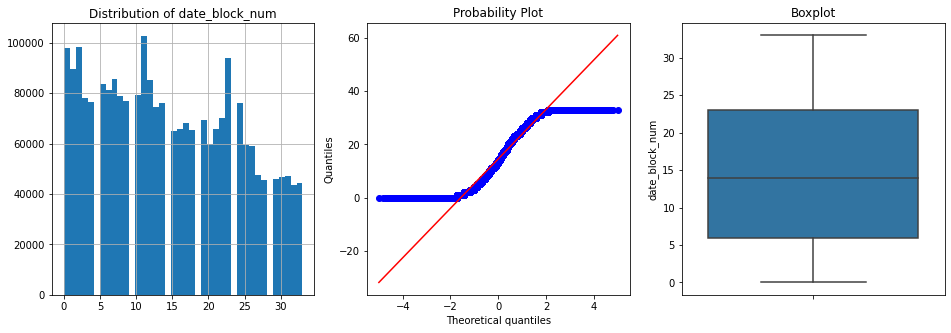

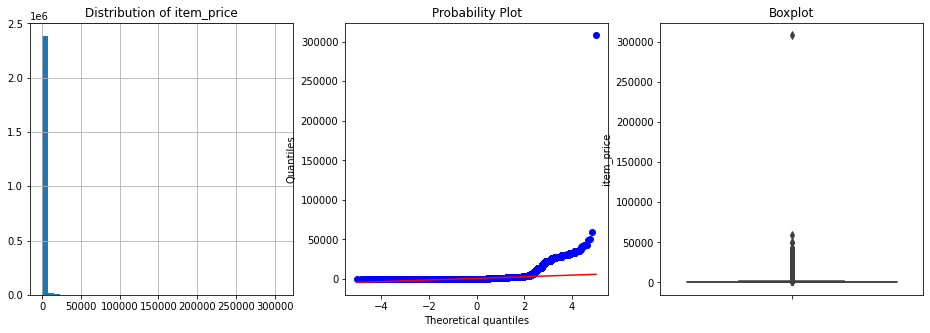

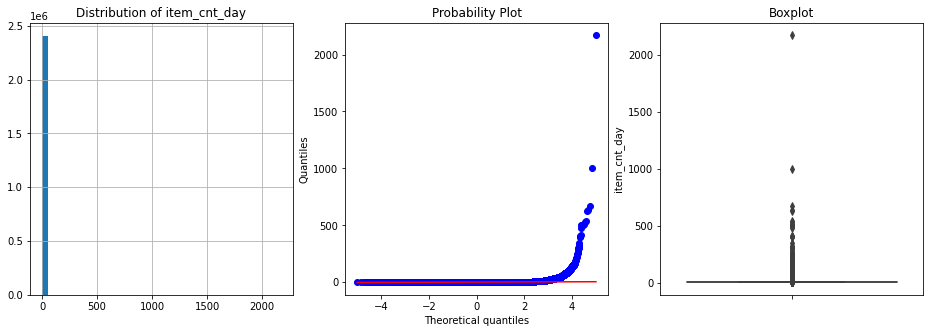

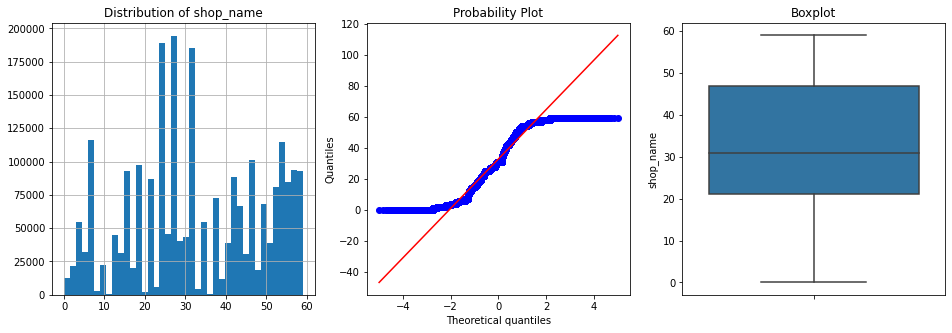

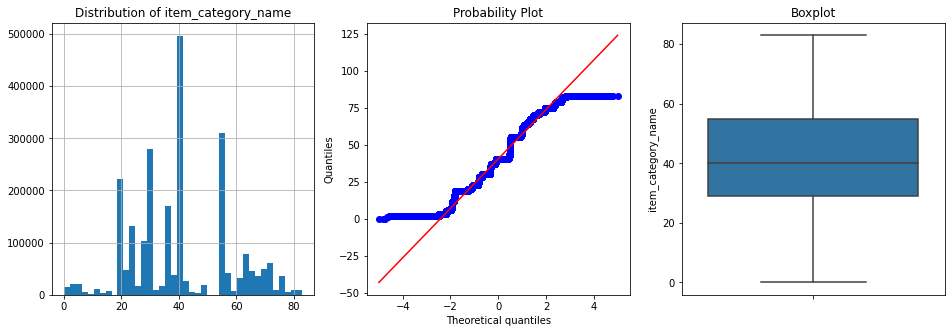

In [87]:
# Check the distribution of the data

data = train[['date_block_num', 'item_price', 'item_cnt_day', 'shop_name', 'item_category_name']]

# Func
def num_plot(df, var):
 fig = plt.figure(figsize=(16,5))
 plt.subplot(1,3,1)
 df[var].hist(bins = 40)
 plt.title(f"Distribution of {var}")

 plt.subplot(1,3,2)
 stats.probplot(df[var], dist='norm', plot=plt)
 plt.ylabel('Quantiles')

 plt.subplot(1,3,3)
 sns.boxplot(y = df[var])
 plt.title("Boxplot")
 plt.show()

for var in data:
 num_plot(train, var)

In [88]:
# Get rid of the outliers

train.drop(train[train.item_price > 3 * train.item_price.std()].index, inplace=True)
train.drop(train[train.item_cnt_day > 3 * train.item_cnt_day.std()].index, inplace=True)

In [89]:
# Calculate revenue
train['item_revenue'] = train.item_cnt_day * train.item_price

In [90]:
pt = PowerTransformer(method = 'yeo-johnson')

numerical_headers = train.columns

for i in numerical_headers:
 train[i] = pt.fit_transform(train[i].values.reshape(-1, 1))

train.skew()

date_block_num       -0.203084
item_price            0.033594
item_cnt_day          2.651492
item_name            -0.178906
shop_name            -0.210456
item_category_name   -0.018105
month                -0.153043
year                  0.000000
item_revenue          0.014650
dtype: float64

In [91]:
train.head()

,date_block_num,item_price,item_cnt_day,item_name,shop_name,item_category_name,month,year,item_revenue
0,-1.91773,0.768366,-0.334857,1.598279,1.535070,-0.156241,-1.304452,-3.236300e-14,0.653647
1,-1.91773,0.655214,-0.334857,-1.327873,-0.446377,1.031380,-0.945877,-3.236300e-14,0.553023
3,-1.91773,1.365920,-0.334857,-1.327307,-0.446377,1.031380,-0.017722,-3.236300e-14,1.171523
4,-1.91773,0.871890,-0.334857,-1.327024,-0.446377,0.923590,-1.706505,-3.236300e-14,0.744974
5,-1.91773,-0.301138,-0.334857,-1.324480,-0.446377,1.084925,1.029202,-3.236300e-14,-0.333483


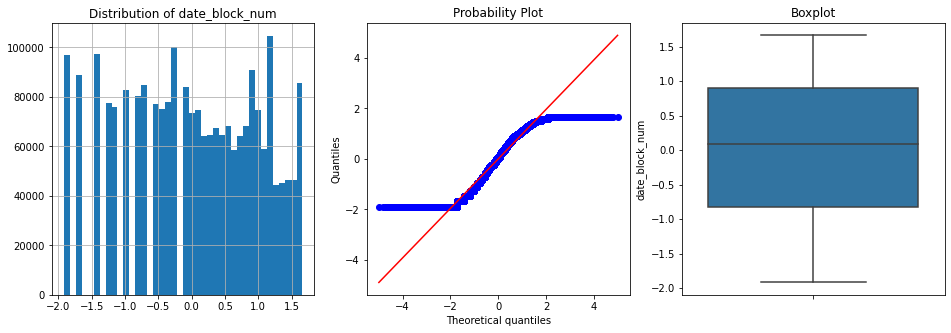

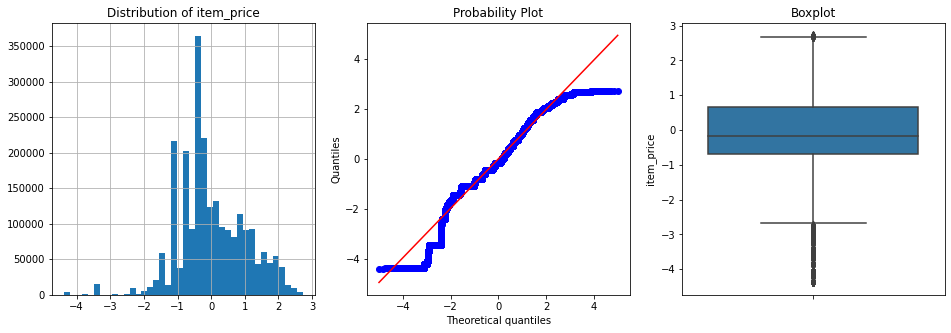

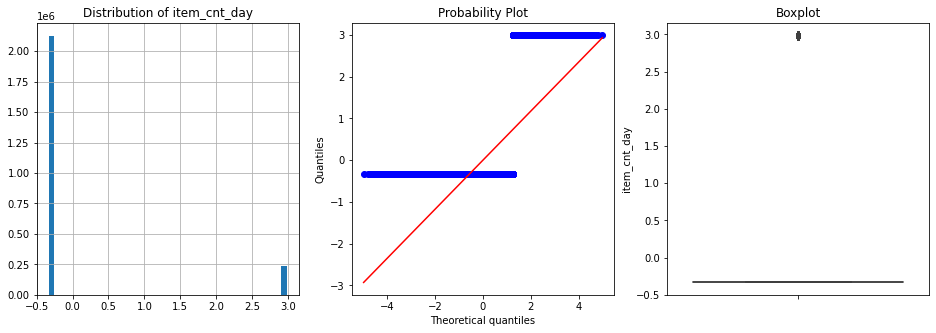

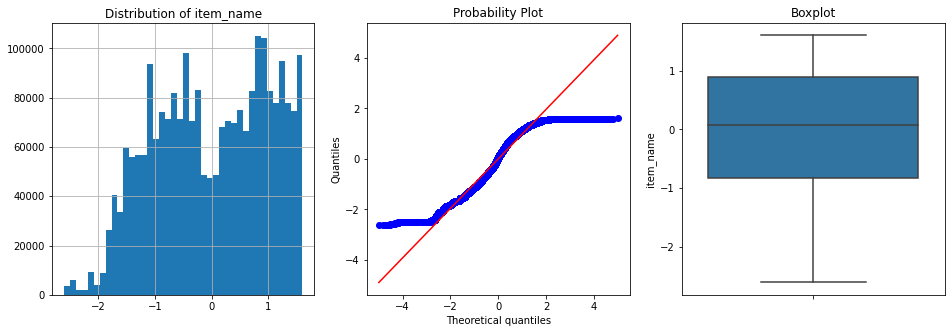

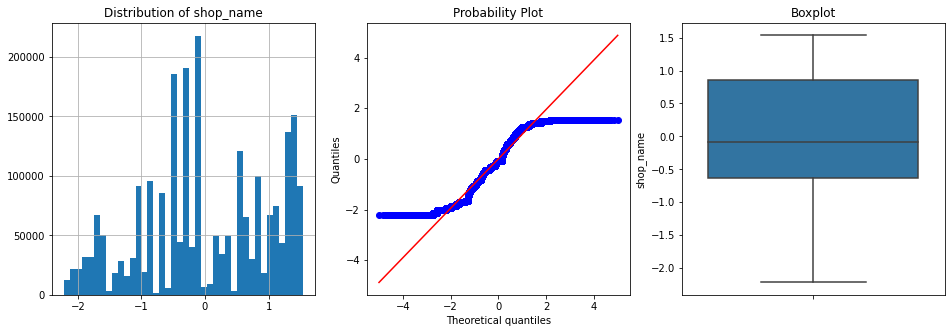

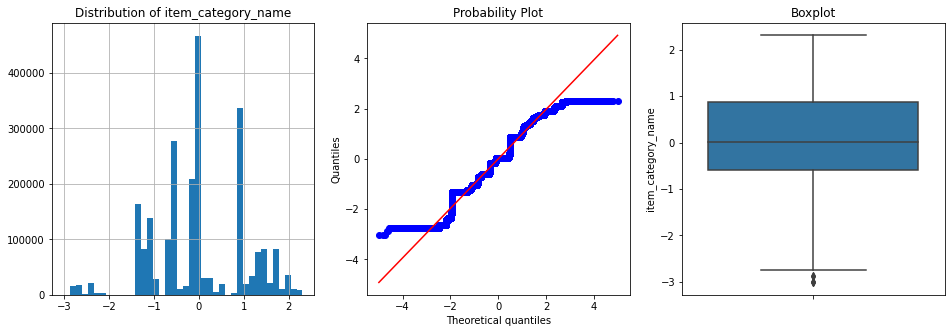

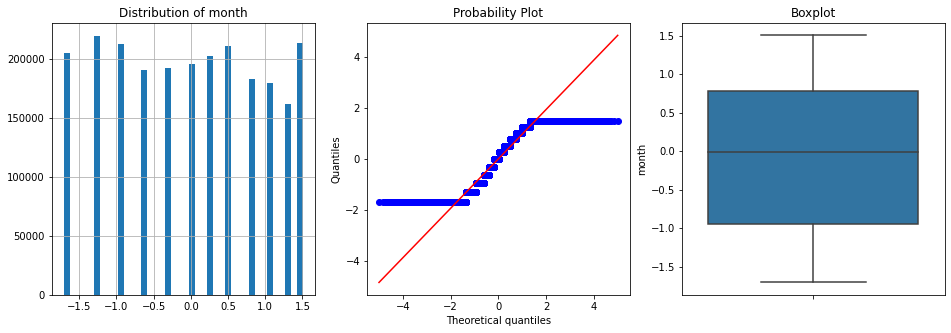

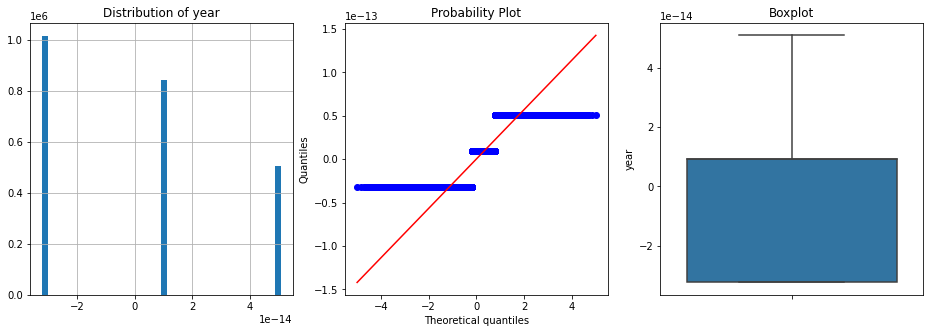

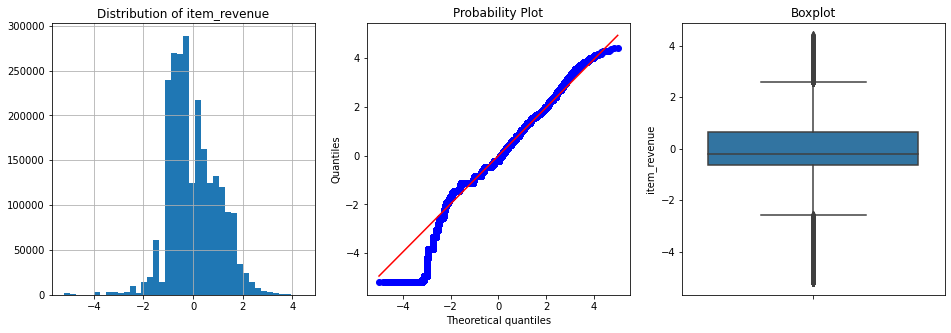

In [92]:
for var in train:
 num_plot(train, var)

In [93]:
Y = train['item_cnt_day']
X = train.drop(['item_cnt_day'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 42)

In [94]:
model = XGBClassifier()

model.fit(X_train, y_train)

c:\Users\Administrator\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

c:\Users\Administrator\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



[21:44:34] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [95]:
pred = model.predict(X_test)

In [96]:
# Measure the accuracy

from sklearn.metrics import mean_squared_error


print(mean_squared_error(y_true=y_test, y_pred=pred))

2.3317163144210486e-05
